In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Required Libraries**

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist.axislines import Subplot
from copy import copy, deepcopy
from pickle import dump, load
import seaborn as sns
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/utils')
from utils import preProcessing_clustering

# **Import Data**

In [3]:
file_path = '/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/data/Electricity Load Diagrams 2011-14.csv'
df = pd.read_csv(file_path)
df['Datetime'] = pd.to_datetime(df['Datetime'])
print(df)

                  Datetime    MT_001  ...      MT_369       MT_370
0      2011-01-01 00:15:00  0.000000  ...    0.000000     0.000000
1      2011-01-01 00:30:00  0.000000  ...    0.000000     0.000000
2      2011-01-01 00:45:00  0.000000  ...    0.000000     0.000000
3      2011-01-01 01:00:00  0.000000  ...    0.000000     0.000000
4      2011-01-01 01:15:00  0.000000  ...    0.000000     0.000000
...                    ...       ...  ...         ...          ...
140251 2014-12-31 23:00:00  2.538071  ...  651.026393  7621.621622
140252 2014-12-31 23:15:00  2.538071  ...  669.354839  6702.702703
140253 2014-12-31 23:30:00  2.538071  ...  670.087976  6864.864865
140254 2014-12-31 23:45:00  1.269036  ...  646.627566  6540.540541
140255 2015-01-01 00:00:00  2.538071  ...  673.020528  7135.135135

[140256 rows x 371 columns]


# **Pre-Process Data**

1.   Group data by Household ID
2.   Convert DateTime to Pandas DateTime for coherence - then sort by DateTime
3.   Add NANs if DateTime is not continuous for any household
4.   Make NAN to 0 to handle missing data
5.   Add eGauge readings of 'grid', 'solar', and 'solar2' to calculate net electricity consumption reading of the household
6.   If net electricity consumption value is -ve or 0, consider it as missing value by converting it to NAN
7.   Group data for each household by date
8.   Return final rawData of shape (nHouseholds, nDays, readingsPerDay)

Check Continuity

In [4]:
def check_continuity_TS(dataframe, timeColumn, secondsGap):
    prev_value = 0
    contflag = True
    for key, value in dataframe[timeColumn].iteritems():
        if not prev_value==0:
            time_diff = (pd.to_datetime(value, dayfirst=True) - pd.to_datetime(prev_value, dayfirst=True)).total_seconds()
            if not time_diff == secondsGap:
                print('Found error at key =', key, 'and time_diff =', time_diff)
                print('value = ', value, '; prev_value = ', prev_value)
                contflag = False
            prev_value = value
    return contflag

print(check_continuity_TS(df, 'Datetime', 900))

True


Check NANs and -ve(s)

In [5]:
print('Total number of NAN values = ', sum(df.isna().sum()))
print('Total number of -ve values = ', sum(df[df.columns[1:]].lt(0).sum()))

Total number of NAN values =  0
Total number of -ve values =  0


Check 0s year-wise

In [6]:
df2011 = df[df['Datetime'].dt.year == 2011]
#print(df2011)
# 4 Readings per hour * 24 hours per day * 365 (or 366) days in the year * 370 households
print(f'Total number of 0 values in year 2011 = {sum(df2011[df2011.columns[1:]].eq(0).sum())}, i.e. {sum(df2011[df2011.columns[1:]].eq(0).sum())*100/(4*24*365*370)}%')
df2012 = df[df['Datetime'].dt.year == 2012]
#print(df2012)
print(f'Total number of 0 values in year 2012 = {sum(df2012[df2012.columns[1:]].eq(0).sum())}, i.e. {sum(df2012[df2012.columns[1:]].eq(0).sum())*100/(4*24*366*370)}%')
df2013 = df[df['Datetime'].dt.year == 2013]
#print(df2013)
print(f'Total number of 0 values in year 2013 = {sum(df2013[df2013.columns[1:]].eq(0).sum())}, i.e. {sum(df2013[df2013.columns[1:]].eq(0).sum())*100/(4*24*365*370)}%')
df2014 = df[df['Datetime'].dt.year == 2014]
#print(df2014)
print(f'Total number of 0 values in year 2014 = {sum(df2014[df2014.columns[1:]].eq(0).sum())}, i.e. {sum(df2014[df2014.columns[1:]].eq(0).sum())*100/(4*24*365*370)}%')

Total number of 0 values in year 2011 = 7413077, i.e. 57.178490990990994%
Total number of 0 values in year 2012 = 1653859, i.e. 12.721679158666863%
Total number of 0 values in year 2013 = 1151001, i.e. 8.877892447241763%
Total number of 0 values in year 2014 = 239402, i.e. 1.8465537455263483%


Count days where no value is 0 for any household

In [7]:
noZeroDays = 0
years = 2011+np.arange(4)
months = 1+np.arange(12)
days = 1 + np.arange(31)
for year in years:
    df1 = df[df['Datetime'].dt.year == year]
    for month in months:
        df2 = df1[df1['Datetime'].dt.month == month]
        for day in days:
            df3 = df2[df2['Datetime'].dt.day == day]
            if not df3.empty:
                # Calculate the percentage of zeroes in that day & Compare
                if sum(df3[df3.columns[1:]].eq(0).sum())*100/(4*24*370) < 1.5:
                    noZeroDays +=1
print(noZeroDays)

160


In [8]:
test_df = deepcopy(df)
np_test_df = np.array(test_df[test_df.columns[1:]].values.tolist())
np_test_df = np.where(np_test_df>0, 1, 0)

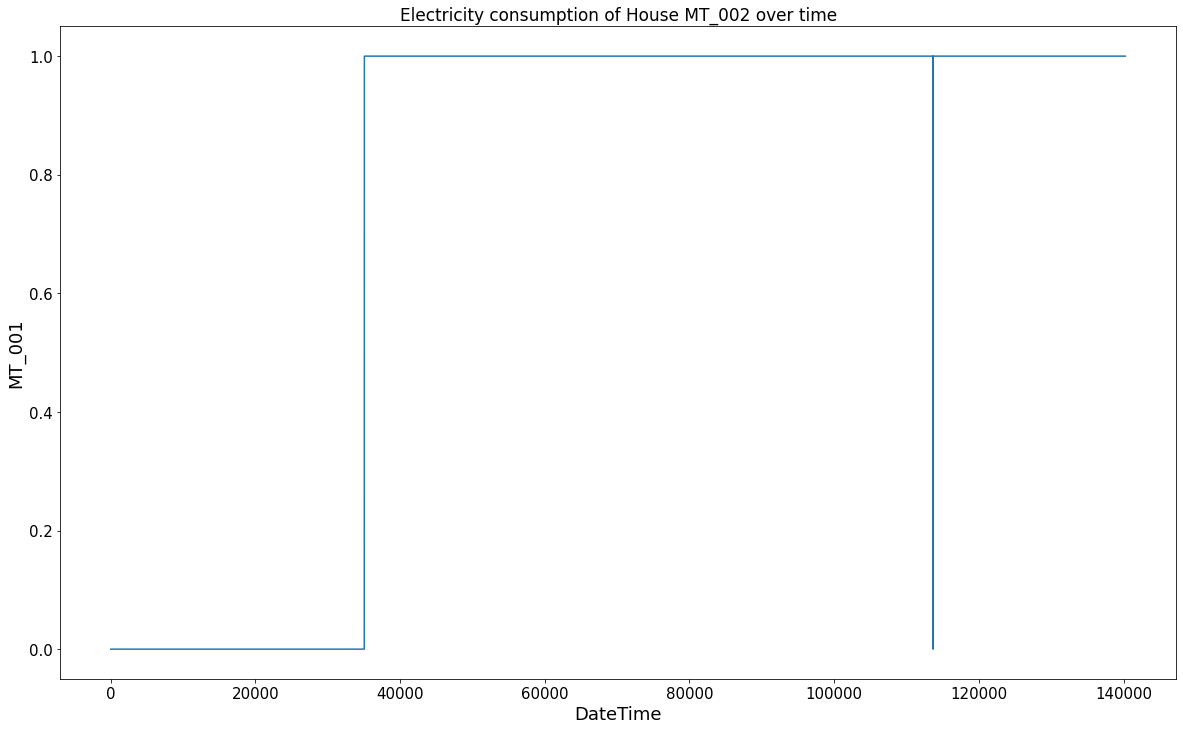

In [9]:
houseNames = df.columns.values.tolist()[1:]
houseID = 2

plt.figure(figsize=(20, 12))
plt.rc('font', size=15)         # controls default text sizes
plt.rc('axes', titlesize=17)    # fontsize of the axes title
plt.rc('axes', labelsize=17)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)   # fontsize of the tick labels
plt.rc('ytick', labelsize=15)   # fontsize of the tick labels
plt.rc('legend', fontsize=15)   # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.plot(np_test_df[:, houseID-1])
plt.xlabel('DateTime', fontsize=18)
plt.ylabel(houseNames[0], fontsize=18)
plt.title('Electricity consumption of House ' + houseNames[houseID-1] + ' over time')
plt.show()

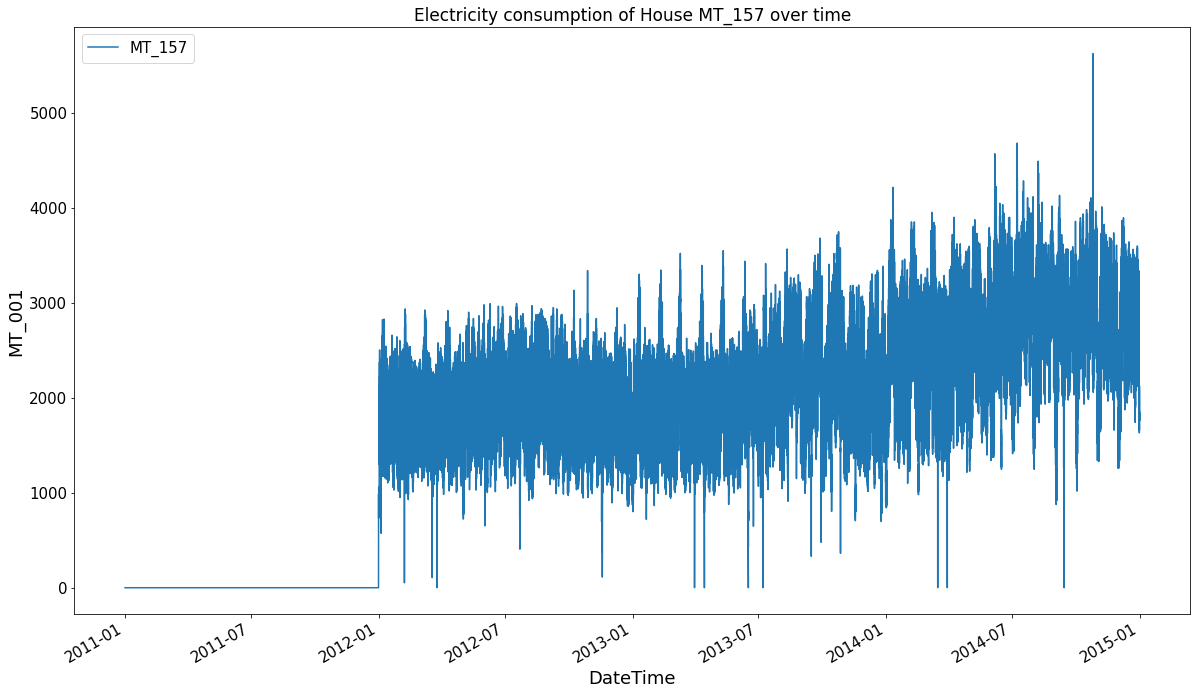

['MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005', 'MT_006', 'MT_007', 'MT_008', 'MT_009', 'MT_010', 'MT_011', 'MT_012', 'MT_013', 'MT_014', 'MT_015', 'MT_016', 'MT_017', 'MT_018', 'MT_019', 'MT_020', 'MT_021', 'MT_022', 'MT_023', 'MT_024', 'MT_025', 'MT_026', 'MT_027', 'MT_028', 'MT_029', 'MT_030', 'MT_031', 'MT_032', 'MT_033', 'MT_034', 'MT_035', 'MT_036', 'MT_037', 'MT_038', 'MT_039', 'MT_040', 'MT_041', 'MT_042', 'MT_043', 'MT_044', 'MT_045', 'MT_046', 'MT_047', 'MT_048', 'MT_049', 'MT_050', 'MT_051', 'MT_052', 'MT_053', 'MT_054', 'MT_055', 'MT_056', 'MT_057', 'MT_058', 'MT_059', 'MT_060', 'MT_061', 'MT_062', 'MT_063', 'MT_064', 'MT_065', 'MT_066', 'MT_067', 'MT_068', 'MT_069', 'MT_070', 'MT_071', 'MT_072', 'MT_073', 'MT_074', 'MT_075', 'MT_076', 'MT_077', 'MT_078', 'MT_079', 'MT_080', 'MT_081', 'MT_082', 'MT_083', 'MT_084', 'MT_085', 'MT_086', 'MT_087', 'MT_088', 'MT_089', 'MT_090', 'MT_091', 'MT_092', 'MT_093', 'MT_094', 'MT_095', 'MT_096', 'MT_097', 'MT_098', 'MT_099', 'MT_100',

In [10]:
houseNames = df.columns.values.tolist()[1:]

houseID = 156

plt.rc('font', size=15)         # controls default text sizes
plt.rc('axes', titlesize=17)    # fontsize of the axes title
plt.rc('axes', labelsize=17)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)   # fontsize of the tick labels
plt.rc('ytick', labelsize=15)   # fontsize of the tick labels
plt.rc('legend', fontsize=15)   # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
df.plot(x='Datetime', y=houseNames[houseID], figsize=(20, 12))
plt.legend(loc='best', fontsize=15)
plt.xlabel('DateTime', fontsize=18)
plt.ylabel(houseNames[0], fontsize=18)
plt.title('Electricity consumption of House ' + houseNames[houseID] + ' over time')
plt.show()

print(houseNames)

## Extract daily load demand profiles (given household number)

In [11]:
# HouseID is same as the house number in the dataset
def get_daily_profiles(df, houseID):
    houseNames = df.columns.values.tolist()[1:]
    # Subtract 1 from houseID to convert it into an index of housenames
    houseID = houseID - 1
    counter = 0
    for date, group in df.groupby([df['Datetime'].dt.date])[houseNames[houseID]]:
        if any(v<=0 or np.isnan(v) for v in group.values):
            continue
        elif not len(group.values) == 4*24:
            continue
        else:
            counter+=1
    daily_profiles = np.empty((counter, 4*24))
    counter = 0
    for date, group in df.groupby([df['Datetime'].dt.date])[houseNames[houseID]]:
        if any(v<=0 or np.isnan(v) for v in group.values):
            continue
        elif not len(group.values) == 4*24:
            continue
        else:
            daily_profiles[counter, :] = np.array(group.values)
            counter+=1
    return daily_profiles

#daily_profiles = get_daily_profiles(df, 2)
#print(daily_profiles.shape)

1.   Extract median daily profiles for each household
2.   Normalize the median profiles to complete pre-processing


In [19]:
def preProcess_complete(df):
    houseNames = df.columns.values.tolist()[1:]
    preProcessedData = np.empty((len(houseNames), 4*24))
    for houseID in range(len(houseNames)):
        daily_profiles = get_daily_profiles(df, houseID+1)
        if len(daily_profiles) < 900:
            preProcessedData[houseID, :] = np.nan
        else:
            median_profile = np.median(daily_profiles, axis=0)
            median_profile_norm = median_profile / np.linalg.norm(median_profile)
            preProcessedData[houseID, :] = median_profile_norm
            #print(houseID+1, median_profile_norm.shape)
    return preProcessedData

preProcessedData = preProcess_complete(df)
print(preProcessedData.shape)

(370, 96)


In [20]:
filtered_preProcessedData = preProcessedData.copy()
filtered_preProcessedData = filtered_preProcessedData[~np.isnan(filtered_preProcessedData).any(axis=1), :]
filtered_preProcessedData = filtered_preProcessedData[~np.isinf(filtered_preProcessedData).any(axis=1), :]
print(filtered_preProcessedData.shape)

(315, 96)


# **Save the Preprocessed Data**

In [21]:
dump(filtered_preProcessedData, open('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/data/preProcessed_loadDiagrams3.pkl', 'wb'))